# CCE3 Mooring - Data Processing 

**Purpose**: Code for processing CCE3 mooring observations. CCE3 mooring is real-time telemetered data that is NOT QC'd yet. It can be found found [here](https://mooring.ucsd.edu/cce3/cce3_01/csv/). 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [2]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
import gsw
import matplotlib as cm
import cmocean
import glob 
from scipy.interpolate import interp1d

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_mooring       = 'CCE3' # Specifies which mooring will analyzed. 
option_obs           = 'CTD'  # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

# Set plotting parameters 
fontsize = 14

Load and process CCE3 data 

In [4]:
# Set root path
ROOT = "/data/CCE/" + option_mooring + "/" + option_obs + "/"

# Set filenames
filenames_temp =PATH + ROOT + "temp.csv"
filenames_sal =PATH + ROOT + "sal.csv"

# ----------------------------------------------------------------
# STEP 1 - Read in data from CSV file and splice the data 
# ----------------------------------------------------------------

#--- Temperature ---# 

# Load the CSV
df = pd.read_csv(filenames_temp)  

# Convert time column to datetime (the time is Unix time * 1000 so we need to divide by 1000 to get seconds)
time_unix_ms = df.iloc[:, 0]  
time_dt_c = pd.to_datetime(time_unix_ms / 1000, unit='s') 
time_dt_t = time_dt_c.to_numpy()

# Get the column names for temperature columns (Skip the first column (time))
temp_cols = df.columns[1:] 

# Extract depths from column names (e.g., "T_1m" -> 1)
depth_t = np.array([int(col.split('_')[1].replace('m', '')) for col in temp_cols])

# Extract temperature data into 2D array: (depth,time)
temp_r = df[temp_cols].to_numpy().T

#--- Practical Salinity ---# 

# Load the CSV
df = pd.read_csv(filenames_sal)  

# Convert time column to datetime (the time is Unix time * 1000 so we need to divide by 1000 to get seconds)
time_unix_ms = df.iloc[:, 0]  
time_dt_c = pd.to_datetime(time_unix_ms / 1000, unit='s') 
time_dt_s = time_dt_c.to_numpy()

# Get the column names for temperature columns (Skip the first column (time))
sal_cols = df.columns[1:] 

# Extract depths from column names (e.g., "T_1m" -> 1)
depth_s = np.array([int(col.split('_')[1].replace('m', '')) for col in temp_cols])

# Extract temperature data into 2D array: (depth,time)
sal_r = df[sal_cols].to_numpy().T

# ----------------------------------------------------------------
# STEP 2 - Check for consistency between temperature and salinity
# ----------------------------------------------------------------

# Check if depths are consistent
if np.array_equal(depth_t, depth_s): 

    # Set depth array
    depth = depth_t

# Check if times are consistent
if np.array_equal(time_dt_t, time_dt_s): 

    # Set depth array
    time_dt = time_dt_t

# ----------------------------------------------------------------
# STEP 3 - Bin average time onto a regular grid
# ----------------------------------------------------------------

# Define bin size
T = 1
dt = np.timedelta64(T, 'h') # np.timedelta64(30, 'm')

# Create bin edges and centers
time_start = min(time_dt)
time_end   = max(time_dt)
time_edges = np.arange(time_start, time_end + dt, dt)
time_bin = np.array(time_edges[:-1]) + dt / 2

# Set dimensions of arrays
n_depths = temp_r.shape[0]
n_bins = len(time_bin)

# Initialize arrays
#pres_b = np.ma.masked_all((n_depths, n_bins))
sal_b  = np.ma.masked_all((n_depths, n_bins))
temp_b = np.ma.masked_all((n_depths, n_bins))

# Convert to masked arrays
sal_r = np.ma.masked_invalid(sal_r)
temp_r = np.ma.masked_invalid(temp_r)

# Loop over depths
for i in range(n_depths):

    # Create DataFrame with time and variables at the ith depth and convert masked values to nans
    df = pd.DataFrame({
        'time': time_dt,
        #'pres': pres_r[i, :].filled(np.nan), 
        'sal' : sal_r[i, :].filled(np.nan), 
        'temp': temp_r[i, :].filled(np.nan)
    })

    # Assign each data point to a bin
    df['bin'] = pd.cut(df['time'], bins=time_edges, labels=time_bin, include_lowest=True)

    # Compute bin-averaged data and water depth
    grouped = df.groupby('bin',observed=False).agg(
        #mean_pres = ('pres', 'mean'),
        mean_sal  = ('sal', 'mean'),
        mean_temp = ('temp', 'mean') 
    ).reset_index()

    # Align to bin centers
    #pres_series = pd.Series(data=grouped['mean_pres'].values, index=grouped['bin'].astype('datetime64[ns]'))
    sal_series  = pd.Series(data=grouped['mean_sal'].values,  index=grouped['bin'].astype('datetime64[ns]'))
    temp_series = pd.Series(data=grouped['mean_temp'].values, index=grouped['bin'].astype('datetime64[ns]'))

    # Fill into output array (align bin centers)
    for j, t in enumerate(time_bin):
        #pres_b[i, j] = pres_series.get(t, np.nan)
        sal_b[i, j]  = sal_series.get(t, np.nan)
        temp_b[i, j] = temp_series.get(t, np.nan)

# Place the data into the 2D arrays and mask NaNs
# pres = np.ma.masked_invalid(pres_b)
sal = np.ma.masked_invalid(sal_b)
temp = np.ma.masked_invalid(temp_b)
time = time_bin


Plot the presure, temperature, and salinity time series

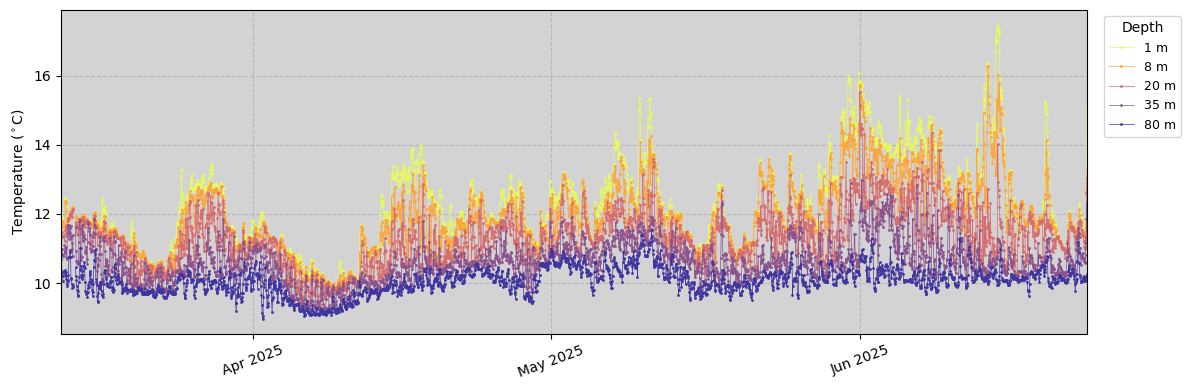

In [5]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap fro depths
cmap = cmocean.cm.thermal.reversed()
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, temp[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Temperature ($^\circ$C)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

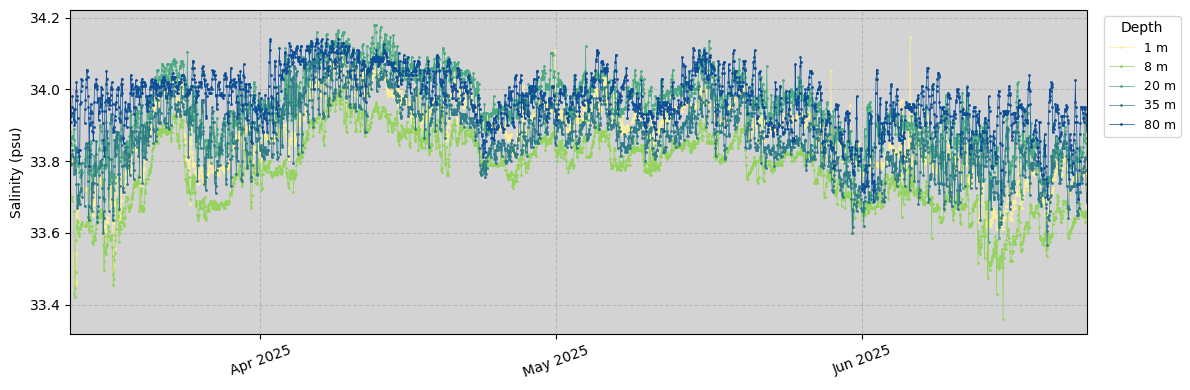

In [6]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap fro depths
cmap = cmocean.cm.haline.reversed()
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, sal[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Salinity (psu)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Process the gps data

In [7]:
# Set root path
ROOT = "/data/CCE/" + option_mooring + "/"

# Set filename
filenames_gps = PATH + ROOT + "gps.csv"

# ----------------------------------------------------------------
# STEP 1 - Read in data from CSV file and splice the data 
# ----------------------------------------------------------------

# Load CSV
df = pd.read_csv(filenames_gps)  # replace with your actual file name

# Extract time column and convert to datetime64
time_unix_ms = df.iloc[:, 0]  # assuming first column is time in milliseconds
time_gps = pd.to_datetime(time_unix_ms / 1000, unit='s').to_numpy()

# Extract individual GPS columns as NumPy arrays
lat_r = df['lat'].to_numpy()
lon_r = df['lon'].to_numpy()

# Compute the mean longitude and latitude 
lon_m = np.nanmean(lon_r[lon_r < -120.536])
lat_m = np.nanmean(lat_r[lat_r < 34.46])

# Set outliers to nans
lon_r[lon_r > -120.536] = np.nan
lat_r[lat_r > 34.46] = np.nan

# ----------------------------------------------------------------
# STEP 3 - Bin average time onto a regular grid
# ----------------------------------------------------------------

# Define bin size
T = 1
dt = np.timedelta64(T, 'h') # np.timedelta64(30, 'm')

# Create bin edges and centers
time_start = min(time_gps)
time_end   = max(time_gps)
time_edges = np.arange(time_start, time_end + dt, dt)
time_bin = np.array(time_edges[:-1]) + dt / 2

# Set dimensions of arrays
n_bins = len(time_bin)

# Initialize arrays
lat_b  = np.ma.masked_all((n_bins))
lon_b = np.ma.masked_all((n_bins))

# Convert to masked arrays
lat_r = np.ma.masked_invalid(lat_r)
lon_r = np.ma.masked_invalid(lon_r)

# Create DataFrame with time and variables at the ith depth and convert masked values to nans
df = pd.DataFrame({
    'time': time_gps,
    'lat' : lat_r.filled(np.nan), 
    'lon': lon_r.filled(np.nan)
})

# Assign each data point to a bin
df['bin'] = pd.cut(df['time'], bins=time_edges, labels=time_bin, include_lowest=True)

# Compute bin-averaged data and water depth
grouped = df.groupby('bin',observed=False).agg(
    mean_lat  = ('lat', 'mean'),
    mean_lon = ('lon', 'mean') 
).reset_index()

# Align to bin centers
lat_series  = pd.Series(data=grouped['mean_lat'].values,  index=grouped['bin'].astype('datetime64[ns]'))
lon_series = pd.Series(data=grouped['mean_lon'].values, index=grouped['bin'].astype('datetime64[ns]'))

# Fill into output array (align bin centers)
for j, t in enumerate(time_bin):
    lat_b[j]  = lat_series.get(t, np.nan)
    lon_b[j] = lon_series.get(t, np.nan)

# Place the data into the 2D arrays and mask NaNs
lat = np.ma.masked_invalid(lat_b)
lon = np.ma.masked_invalid(lon_b)
time_gps_bin = time_bin

# Check if times are consistent
np.array_equal(time, time_gps_bin)


True

Compute potential density at several reference levels

In [8]:
# Set dimnesions
ndepth,ntime = np.shape(temp)

# Convert depths to the coordinate system with positive z up 
depth_conv = -1 * depth  # Units: m

# Initialize an array for the pressure, conservative temperature, absolute salinity, and in-situ/potential density 
pres     = np.zeros_like(temp)
CT       = np.zeros_like(temp)
SA       = np.zeros_like(temp)
density  = np.zeros_like(temp)
sigma0   = np.zeros_like(temp)
sigma1   = np.zeros_like(temp)
sigma2   = np.zeros_like(temp)
sigma3   = np.zeros_like(temp)

# Loop through time steps 
for idata in range(0,ntime):

    # Compute pressure from depth and latitude
    pres[:,idata] = gsw.conversions.p_from_z(depth_conv,lat[idata])  # Units: dbar

    # Compute absolute salinity 
    SA[:,idata] = gsw.conversions.SA_from_SP(sal[:,idata], pres[:,idata], lon[0], lat[0]) # Units: g/kg

    # Compute Conservative temperature from absolute salinity, in-situ temperature and pressure
    CT[:,idata] = gsw.conversions.CT_from_t(SA[:,idata], temp[:,idata], pres[:,idata])  # Units: degrees Celcius

    # Compute in-situ and potential density (with reference pressure of 0 dbar) 
    density[:,idata] = gsw.density.rho(SA[:,idata],CT[:,idata],pres[:,idata])  # Units: kg/m^3
    sigma0[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3
    sigma1[:,idata] = gsw.density.sigma1(SA[:,idata], CT[:,idata])  # Units: kg/m^3
    sigma2[:,idata] = gsw.density.sigma2(SA[:,idata], CT[:,idata])  # Units: kg/m^3
    sigma3[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3

Plot conservative temperature, absolute salinity, potential density, and pressure 

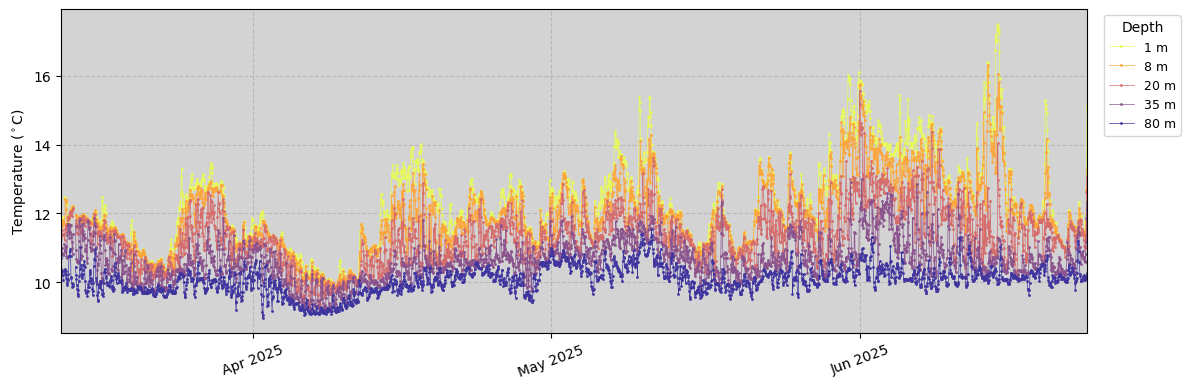

In [9]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap fro depths
cmap = cmocean.cm.thermal.reversed()
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, CT[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Temperature ($^\circ$C)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

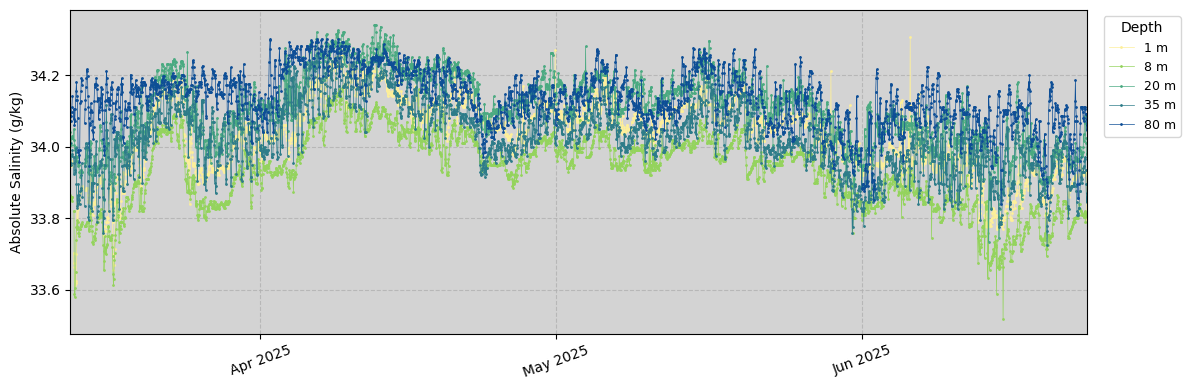

In [10]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap from depths
cmap = cmocean.cm.haline.reversed()
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, SA[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Absolute Salinity (g/kg)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

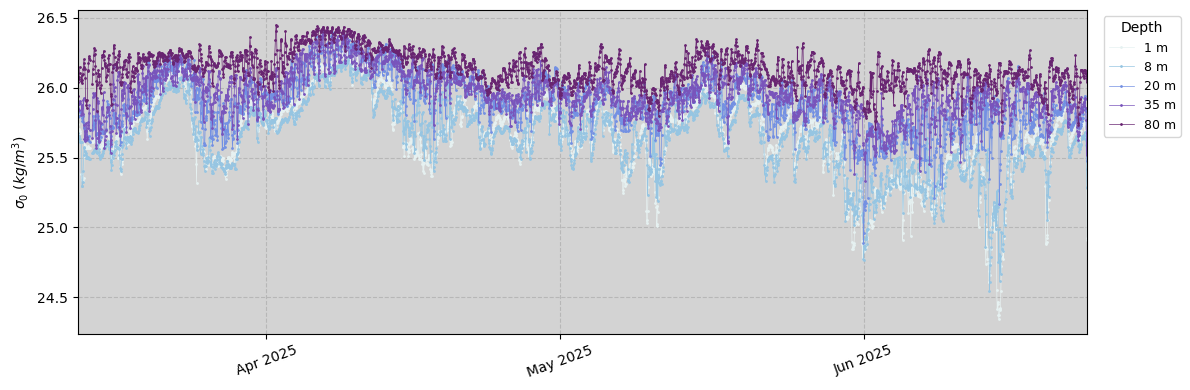

In [11]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap fro depths
cmap = cmocean.cm.dense
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, sigma0[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"$\sigma_0$ ($kg/m^3$)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

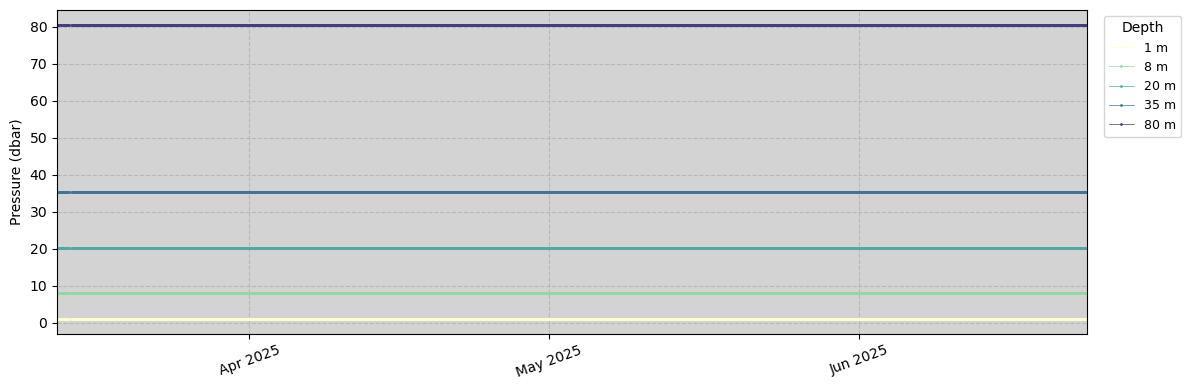

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap fro depths
cmap = cmocean.cm.deep
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, pres[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Pressure (dbar)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Save intermediate data in a netCDF for future use

In [13]:
# Set time and space parameters
start_time = time[0]                             # Specifies the start time of the event period
end_time = time[-1]                              # Specifies the end time of the event period
start_time_py = pd.to_datetime(start_time).to_pydatetime()
end_time_py = pd.to_datetime(end_time).to_pydatetime()

# Save variables in data arrays

#--- Sea State Varibles ---# 
Pressure = xr.DataArray(data=pres, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Pressure profiles time series.',
                        units='dbar'
                        )
)

Density = xr.DataArray(data=density, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='In-situ Density profiles time series.',
                        units='kg/m^3'
                        )
) 

SIG0 = xr.DataArray(data=sigma0, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at the sea surface.',
                        units='kg/m^3'
                        )
) 

SIG1 = xr.DataArray(data=sigma1, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at 1000 meters.',
                        units='kg/m^3'
                        )
) 

SIG2 = xr.DataArray(data=sigma2, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at 2000 meters.',
                        units='kg/m^3'
                        )
) 

SIG3 = xr.DataArray(data=sigma3, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at 3000 meters.',
                        units='kg/m^3'
                        )
) 

CTemp = xr.DataArray(data=CT, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Conservative temperature profiles time series.',
                        units='degrees Celcius'
                        )
) 

ASal = xr.DataArray(data=SA, 
                    dims=['depth','time',],
                    coords=dict(depth=depth,time=time),
                    attrs=dict(
                        description='Absolute Salinity profiles time series.',
                        units='g/kg'
                        )
) 

#--- Latitude and Longitude Coordinates ---# 
LON = xr.DataArray(data=lon_m, 
                    dims=[],  # scalar: no dimension
                    attrs=dict(
                        description='Longitude of the mooring.'
                        )
) 

LAT = xr.DataArray(data=lat_m, 
                    dims=[],  # scalar: no dimension
                    attrs=dict(
                        description='Latitude of mooring.'
                        )
) 

TIME = xr.DataArray(data=time, 
                    dims=['time'],
                    coords=dict(time=time),
                    attrs=dict(
                        description='Time (in datetime formation) for mooring time series.'
                        )
) 

# Create a data set from data arrays 
data = xr.Dataset({'Pressure':Pressure,'Density':Density,'SIG0':SIG0,'SIG1':SIG1,'SIG2':SIG2,'SIG3':SIG3,'CTemp':CTemp,'ASal':ASal,'LON':LON,'LAT':LAT,'TIME':TIME})

# Check if file exists, then delete it
file_path = (PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" +
             option_mooring + "_" + option_obs + "_" +
             str(start_time_py.year) + str(start_time_py.month) + str(start_time_py.day) + "-" +
             str(end_time_py.year) + str(end_time_py.month) + str(end_time_py.day) +
             "_intermediate_data.nc")
if os.path.exists(file_path):
    os.remove(file_path)

# Create netcdf file
data.to_netcdf(file_path,mode='w')